### Created by: Anthony D. Cho
### Last update: 13.11.2021

**Subject**: Classification (MLP, dropout - keras, tensorflow) - Bank Marketing

## Libraries dependencies

In [1]:
from time import time
from collections import Counter
from pandas import set_option, read_csv, DataFrame, to_numeric
set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
from numpy import zeros, where, round

## Pre-processing functions
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split

## Metrics
from sklearn.metrics import confusion_matrix, classification_report

## Imbalance-data functions
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

## tensorflow-Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

## Customized functions

In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

    @param width: width of the graphic display
    @type width: int

    @param height: height of the graphic display
    @type height: int

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()

# Problem: Bank Marketing
**Target**:  The classification goal is to predict if the client will subscribe a term deposit (variable y).

## Data loading
Source: [Bank Marketing](https://archive.ics.uci.edu/ml/datasets/bank+marketing) (UCI Repository)

In [3]:
## Download and uncompress zip file
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
!unzip -u bank.zip

--2021-11-22 00:22:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolviendo archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Conectando con archive.ics.uci.edu (archive.ics.uci.edu)[128.195.10.252]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 579043 (565K) [application/x-httpd-php]
Guardando como: “bank.zip.1”

bank.zip.1          100%[===================>] 565,47K   723KB/s    en 0,8s    

2021-11-22 00:22:29 (723 KB/s) - “bank.zip.1” guardado [579043/579043]

Archive:  bank.zip


In [4]:
## Load data
data = read_csv('bank.csv', sep=';')

## Display number of samples per class
print('Class:\n {} \n'.format(Counter(data['y'])))

## Display first five records
data.head()

Class:
 Counter({'no': 4000, 'yes': 521}) 



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


### Pre-processing

In [5]:
## Split data by Predictors X and target y
X = data.drop(columns=['y'])
y = data['y'].apply(lambda x: 1 if x=='yes' else 0)

## Identify categorical variables
categorical_vars = []
categorical_vars_index = []
for i, col in enumerate(X.columns):
    if data[col].dtype == 'object':
        categorical_vars.append(col)
        categorical_vars_index.append(i)

## Display categorical variables
for i in zip(categorical_vars_index, categorical_vars):
    print(i, end=' ')

(1, 'job') (2, 'marital') (3, 'education') (4, 'default') (6, 'housing') (7, 'loan') (8, 'contact') (10, 'month') (15, 'poutcome') 

In [6]:
start = time()

## Partition: train set, and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20210323)
X_test.reset_index(drop=True, inplace=True)

## Train set: display class counter
print('Class (Raw)(train):\n{} \n'.format(Counter(y_train)))
print('Class (Raw)(test):\n{} \n'.format(Counter(y_test)))

## Balancing data
X_train_balanced, y_train_balanced = SMOTENC(categorical_features=categorical_vars_index,
                                             n_jobs=-1).fit_resample(X_train, y_train)
print('\nClass (balanced):\n{} \n'.format(Counter(y_train_balanced)))

## Convert array to dataframe and casting 'numeric' (object) columns as numeric
X_train_balanced = DataFrame(X_train_balanced, columns=X_train.columns)
for col in X_train_balanced.columns:
    try:
      to_numeric(X_train_balanced[col])
    except:
      pass
    else:
      X_train_balanced[col] = to_numeric(X_train_balanced[col])

## Encoding categorical variables: Ordinal
print('Encoding Ordinal categorical variables...')
labelsOrdinal = {}
labelsOrdinal['default'] = ['no', 'yes']
labelsOrdinal['housing'] = ['no', 'yes']
labelsOrdinal['loan'] = ['no', 'yes']
labelsOrdinal['month'] = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

for col in labelsOrdinal.keys():
    for index, value in enumerate(labelsOrdinal[col]):

        ## Encoding train set
        X_train_balanced[col] = where(X_train_balanced[col] == value, index, X_train_balanced[col])

        ## Encoding test set
        X_test[col] = where(X_test[col] == value, index, X_test[col])

    ## Convert column as integer
    X_train_balanced[col] = X_train_balanced[col].astype(int)
    X_test[col] = X_test[col].astype(int)

## Encoding categorical variables: Nominal
print('Encoding Nominal categorical variables...')
labelsNominal = {}
for col in X_train_balanced.columns:
    if X_train_balanced[col].dtype == 'object':

        ## Encoder instance per variable with raw data (considering all posible terms)
        labelsNominal[col] = LabelBinarizer().fit(data[col])
print('Nominal vars: ', labelsNominal.keys())

for label in labelsNominal.keys():
    
    ## Select column encoder
    encoding = labelsNominal[label]
        
    ## Apply encoding 
    colname = ['{}_{}'.format(label, encoding.classes_[k]) for k in range(len(encoding.classes_))]
    temp_train = encoding.transform(X_train_balanced[label])
    temp_test = encoding.transform(X_test[label])
    
    ## Convert encoded column values to dataframe
    temp_train = DataFrame(data=temp_train, columns=colname)
    temp_test = DataFrame(data=temp_test, columns=colname)
    
    ## Add encoded columns to 
    for col in temp_train.columns:
        X_train_balanced[col] = temp_train[col]
        X_test[col] = temp_test[col]

## Drop original nominal categorical vars
X_train_balanced.drop(columns=labelsNominal.keys(), inplace=True)  
X_test.drop(columns=labelsNominal.keys(), inplace=True) 

## Scaling data (return array as output)
print('Scaling data...')
scale = MinMaxScaler().fit(X_train_balanced)
X_train_balanced = scale.transform(X_train_balanced)
X_test = scale.transform(X_test)

print('\nPre-processing time spent[s]: ', time()-start)

Class (Raw)(train):
Counter({0: 2665, 1: 364}) 

Class (Raw)(test):
Counter({0: 1335, 1: 157}) 


Class (balanced):
Counter({0: 2665, 1: 2665}) 

Encoding Ordinal categorical variables...
Encoding Nominal categorical variables...
Nominal vars:  dict_keys(['job', 'marital', 'education', 'contact', 'poutcome'])
Scaling data...

Pre-processing time spent[s]:  0.9354839324951172


In [7]:
## Variable used to fit model
X_train_model = X_train_balanced
y_train_model = y_train_balanced

X_test_model = X_test
y_test_model = y_test.values

## Display data shape
print('(train shape) X: {}, y: {}'.format(X_train_model.shape, y_train_model.shape))
print('(test shape) X: {}, y: {}'.format(X_test_model.shape, y_test_model.shape))

(train shape) X: (5330, 37), y: (5330,)
(test shape) X: (1492, 37), y: (1492,)


## Model building

In [8]:
## Build model
model = Sequential(name='Bank_marketing')
model.add(layers.Input(shape=X_train_balanced.shape[1]))
model.add(layers.Dense(units=100, activation='relu', name='Dense_01'))
model.add(layers.Dropout(rate=0.5, name='Dropout_01'))
model.add(layers.Dense(units=50, activation='relu', name='Dense_02'))
model.add(layers.Dropout(rate=0.1, name='Dropout_02'))
model.add(layers.Dense(units=1, activation='sigmoid', name='output'))

## Compiler setting
model.compile(loss='binary_crossentropy', metrics=['accuracy', AUC()],
              optimizer=Adam(learning_rate=0.0001))

## Display model
model.summary()

Model: "Bank_marketing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_01 (Dense)             (None, 100)               3800      
_________________________________________________________________
Dropout_01 (Dropout)         (None, 100)               0         
_________________________________________________________________
Dense_02 (Dense)             (None, 50)                5050      
_________________________________________________________________
Dropout_02 (Dropout)         (None, 50)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 8,901
Trainable params: 8,901
Non-trainable params: 0
_________________________________________________________________


In [9]:
start = time()

## Model fitting
history = model.fit(X_train_model, y_train_model, 
                    validation_split=0.1, shuffle=True, 
                    batch_size=30, epochs=50)

print('\nTraining time spent[s]: ', time()-start, end='\n\n')

Epoch 1/50
160/160 [==============================] - 2s 6ms/step - loss: 0.7041 - accuracy: 0.4943 - auc: 0.4917 - val_loss: 0.7324 - val_accuracy: 0.2645 - val_auc: 0.0000e+00
Epoch 2/50
160/160 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.5820 - auc: 0.6129 - val_loss: 0.7209 - val_accuracy: 0.4034 - val_auc: 0.0000e+00
Epoch 3/50
160/160 [==============================] - 0s 2ms/step - loss: 0.6340 - accuracy: 0.6437 - auc: 0.7049 - val_loss: 0.6923 - val_accuracy: 0.5910 - val_auc: 0.0000e+00
Epoch 4/50
160/160 [==============================] - 0s 2ms/step - loss: 0.6163 - accuracy: 0.6599 - auc: 0.7348 - val_loss: 0.6385 - val_accuracy: 0.7242 - val_auc: 0.0000e+00
Epoch 5/50
160/160 [==============================] - 0s 2ms/step - loss: 0.5910 - accuracy: 0.6932 - auc: 0.7669 - val_loss: 0.5898 - val_accuracy: 0.7749 - val_auc: 0.0000e+00
Epoch 6/50
160/160 [==============================] - 0s 2ms/step - loss: 0.5724 - accuracy: 0.7104 - auc: 0.7

Epoch 47/50
160/160 [==============================] - 0s 2ms/step - loss: 0.3614 - accuracy: 0.8490 - auc: 0.9187 - val_loss: 0.2761 - val_accuracy: 0.9043 - val_auc: 0.0000e+00
Epoch 48/50
160/160 [==============================] - 0s 2ms/step - loss: 0.3516 - accuracy: 0.8585 - auc: 0.9248 - val_loss: 0.2650 - val_accuracy: 0.9137 - val_auc: 0.0000e+00
Epoch 49/50
160/160 [==============================] - 0s 2ms/step - loss: 0.3532 - accuracy: 0.8577 - auc: 0.9228 - val_loss: 0.2499 - val_accuracy: 0.9174 - val_auc: 0.0000e+00
Epoch 50/50
160/160 [==============================] - 0s 2ms/step - loss: 0.3411 - accuracy: 0.8573 - auc: 0.9283 - val_loss: 0.2622 - val_accuracy: 0.9081 - val_auc: 0.0000e+00

Training time spent[s]:  19.189342975616455



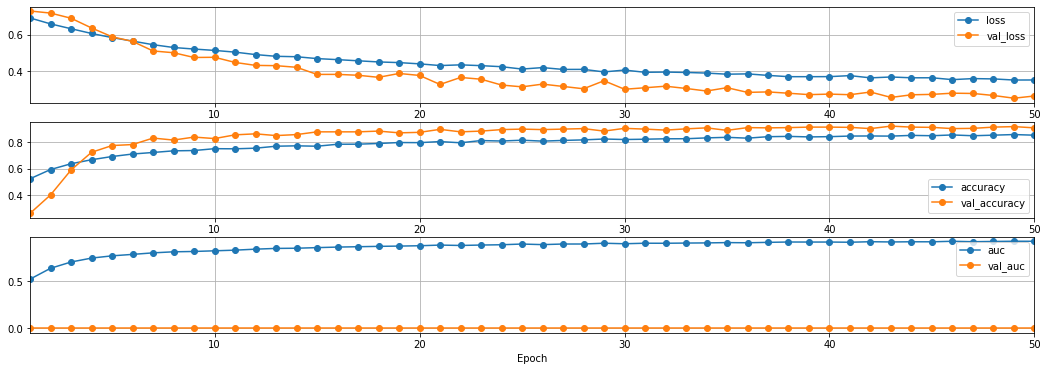

In [10]:
## Display model performance
plot_history(history, width=18)

## Predictions

In [11]:
## Prediction as prob-value
prediction = model.predict(X_test_model)

## Decode value to class
prediction_class = round(prediction.ravel())

In [12]:
prediction_class

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [13]:
## Display confusion matrix
confusion_matrix(y_true=y_test_model, y_pred=prediction_class)

array([[1156,  179],
       [  64,   93]])

In [14]:
## Display number of sample per class in test data
Counter(y_test_model)

Counter({0: 1335, 1: 157})

In [15]:
print(classification_report(y_true=y_test_model, y_pred=prediction_class))

              precision    recall  f1-score   support

           0       0.95      0.87      0.90      1335
           1       0.34      0.59      0.43       157

    accuracy                           0.84      1492
   macro avg       0.64      0.73      0.67      1492
weighted avg       0.88      0.84      0.86      1492



### Best model

Looking into the performance charts, it seems to stabilize (kind of overfit) starting at epoch 49.

In [16]:
## Build model
model = Sequential(name='Bank_marketing')
model.add(layers.Input(shape=X_train_balanced.shape[1]))
model.add(layers.Dense(units=100, activation='relu', name='Dense_01'))
model.add(layers.Dropout(rate=0.5, name='Dropout_01'))
model.add(layers.Dense(units=50, activation='relu', name='Dense_02'))
model.add(layers.Dropout(rate=0.1, name='Dropout_02'))
model.add(layers.Dense(units=1, activation='sigmoid', name='output'))

## Compiler setting
model.compile(loss='binary_crossentropy', metrics=['accuracy', AUC()],
              optimizer=Adam(learning_rate=0.0001))

In [17]:
start = time()

## Model fitting
history = model.fit(X_train_model, y_train_model, 
                    shuffle=True, 
                    batch_size=30, epochs=49)

print('\nTraining time spent[s]: ', time()-start, end='\n\n')

Epoch 1/49
178/178 [==============================] - 1s 2ms/step - loss: 0.7027 - accuracy: 0.4994 - auc_1: 0.5133
Epoch 2/49
178/178 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.6095 - auc_1: 0.6694
Epoch 3/49
178/178 [==============================] - 0s 2ms/step - loss: 0.6329 - accuracy: 0.6676 - auc_1: 0.7221
Epoch 4/49
178/178 [==============================] - 0s 2ms/step - loss: 0.6024 - accuracy: 0.6855 - auc_1: 0.7527
Epoch 5/49
178/178 [==============================] - 0s 2ms/step - loss: 0.5691 - accuracy: 0.7161 - auc_1: 0.7871
Epoch 6/49
178/178 [==============================] - 0s 2ms/step - loss: 0.5404 - accuracy: 0.7340 - auc_1: 0.8102
Epoch 7/49
178/178 [==============================] - 0s 2ms/step - loss: 0.5288 - accuracy: 0.7417 - auc_1: 0.8141
Epoch 8/49
178/178 [==============================] - 0s 2ms/step - loss: 0.5156 - accuracy: 0.7467 - auc_1: 0.8245
Epoch 9/49
178/178 [==============================] - 0s 2ms/step - loss

In [18]:
## Prediction as prob-value
prediction = model.predict(X_test_model)

## Decode value to class
prediction_class = round(prediction.ravel())

In [19]:
## Display confusion matrix
confusion_matrix(y_true=y_test_model, y_pred=prediction_class)

array([[1145,  190],
       [  59,   98]])

In [20]:
## Display classification report
print(classification_report(y_true=y_test_model, y_pred=prediction_class))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1335
           1       0.34      0.62      0.44       157

    accuracy                           0.83      1492
   macro avg       0.65      0.74      0.67      1492
weighted avg       0.89      0.83      0.85      1492

